<a href="https://colab.research.google.com/github/samia-boubaya/project-01-escape-room-game/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **PROJECT 01: ESCAPE ROOM GAME**
### IRONHACK DATA BOOTCAMP

Welcome to escape room quest

You wake up in a couch in a misteryous house with locked doors.
Your mission: Find the keys, unlock each room, and escape to freedom!

In this notebook we start by building the data structures that define the game world, which are: rooms, objects, keys and doors.

**Definition of an escape room:**

The briefing room of an escape room in Tampere, Finland
Escape rooms are inspired by escape room video games, live-action role-playing, point-and-click adventure games, puzzle hunts, interactive theater, and haunted houses. They are also referred to as "room escapes", "escape games", "exit games", or "live escapes".


---

## TEAM NOTES ⭐
### TO ADD:
*   Quiz the player when door is unlocked (comes after the unlock_door function)
*   Tell the player how much time he has left to escape and win this game (print and library of time)
*   Add how much it took the player to finish the game (important in the game_state)
*   Add Live timer and show player their countdown timer (extra)

*   Add list of game_doors to compare with current_space doors to show availabe doors for the player to after that choose which door to try unlock the door using keys from inventory.
*   horror sounds to every room, and KA-CHING for unlocking door, and different winning sound when outside

---

### ERROR HANDLING:
*   Capital letters input error when comparing with our data 
*   Capitalize first letter when printing using .title()
*   No input and enter error






------
------
------
# FINAL GAME PRODUCT

## DATA

### LISTS: ACTIONS, SPACES, ITEMS, DOORS, KEYS

In [7]:
# LIST : actions available to a player
actions = ['explore', 'examine', 'unlock door', 'navigate', 'restart', 'quit','play']
print("Player's actions in the game :",actions)

# LIST : spaces
spaces = ['game room', 'bedroom 1', 'bedroom 2', 'living room','outside']
print("\nSpaces in the game :",spaces)

# LIST : items
items = ['couch', 'piano', 'queen bed', 'double bed', 'dresser', "dining table"]
print("\nItems in the game :",items)

# LIST : doors
doors = ['door A', 'door B', 'door C', 'door D']
print("\nDoors in the game :",doors)

# LIST : keys
keys = ['key door A', 'key door B', 'key door C', 'key door D']
print("\nKeys in the game :",keys)


Player's actions in the game : ['explore', 'examine', 'unlock door', 'navigate', 'restart', 'quit', 'play']

Spaces in the game : ['game room', 'bedroom 1', 'bedroom 2', 'living room', 'outside']

Items in the game : ['couch', 'piano', 'queen bed', 'double bed', 'dresser', 'dining table']

Doors in the game : ['door A', 'door B', 'door C', 'door D']

Keys in the game : ['key door A', 'key door B', 'key door C', 'key door D']


### DICT : GAME AREAS

In [8]:
# Each key in this dictionary represents a room; each value is a list of objects, doors and keys

# Dictionary : GAME AREAS
game_areas = {
    "game room" : ['couch', 'piano', 'door A', 'key door A'],
    "bedroom 1": ['queen bed', 'door A', 'door B', 'door C', 'key door B'],
    "bedroom 2": ['double bed', 'door B', 'dresser', 'key door D', 'key door C'],
    "living room": ["dining table", 'door C', 'door D'],
    "outside": ["freedom"]
}

# List : dictionary Keys
spaces = game_areas.keys()
print("GAME AREAS Dictionary:")
print("Dictionary Keys:\n",spaces,"\n")

# Print dictionary organised
print("Dictionary:\n{   key   :   value     }")
for i in spaces:
  print(i,":",game_areas[i])

GAME AREAS Dictionary:
Dictionary Keys:
 dict_keys(['game room', 'bedroom 1', 'bedroom 2', 'living room', 'outside']) 

Dictionary:
{   key   :   value     }
game room : ['couch', 'piano', 'door A', 'key door A']
bedroom 1 : ['queen bed', 'door A', 'door B', 'door C', 'key door B']
bedroom 2 : ['double bed', 'door B', 'dresser', 'key door D', 'key door C']
living room : ['dining table', 'door C', 'door D']
outside : ['freedom']


### DICT : GAME STATE

In [9]:
# Dictionary : GAME STATE
game_state = {
    'space path' : [], # player current space to navigate and make a space path
    'item path' : [], # to select an item to examine for key; and make an item path
    'door path': [], # to select a door in currentspace and track unlocked doors already and locked ones
    'inventory': [], # to store found keys
    'time': [] , # import library time for time limit max 40min
    'health': 100, # health scores whenever the countdown repeats we lose 25 points

}


# List : dictionary Keys
states = game_state.keys()
print("GAME AREAS Dictionary:")
print("Dictionary Keys:\n",states,"\n")

# Print dictionary organised
print("Dictionary:\n{   key   :   value     }")
for i in states:
  print(i,":",game_state[i])

GAME AREAS Dictionary:
Dictionary Keys:
 dict_keys(['space path', 'item path', 'door path', 'inventory', 'time', 'health']) 

Dictionary:
{   key   :   value     }
space path : []
item path : []
door path : []
inventory : []
time : []
health : 100


----
## FUNCTIONS

The order of the ACTIONS :

0) player_action
// can still input another action or repeat same one ####

1) explore
// update_item_path(item) 
// return list of items in space

2) examine
// return true  if key found
// return false if key not found and not in inventory
// return false if key in inventory
// return 

3) unlock_door
// quiz
// update_door_path(door)

4) navigate
// 
// update_space_path(space)

####  MAIN FUNCTION = PLAYER_ACTION(PLAYER_INPUT)

In [ ]:
def player_action(player_input: str):
    while True:
        game_action = input("Enter your action: ").lower()
        # Invalid input → show available actions and ask again
        if game_action not in actions:
            print(f'\nInvalid action! Please choose one of the following:{actions}')
            player_input = input("Enter your action: ").lower()
            continue
        
        # Quit the game
        if game_action == 'quit':
            print(f"\nPlayer inputs the action: {action}")
            print("Quitting the game. Goodbye!")
            break

        # Restart the game
        elif game_action == 'restart':
            print(f"\nPlayer inputs the action: {action}")
            print("Game restarting!")
            player_input = 'play'
            continue  # Restart goes back to play automatically

        # Play the game
        elif game_action == 'play':
            print(f"\nPlayer inputs the action: {action}")
            print("Starting the game...")
            game_state['space path'].append('game room')
            trigger_event('space')

            # ADD GAME ACTIONS FUNNEL
            action = input("ENTER YOUR NEXT MOVE: ")
            print(f"Performing action: {action}")
            
            while action in actions:
                action = input("INPUT YOUR ACTION HERE: ")
                if action == 'explore':
                    return explore(space)
                
                elif action == 'examine':
                    return examine(space)
                
                elif action == 'unlock door':
                    return unlock(space, door, inventory)
                
                elif action == 'navigate':
                     return navigate(space, door)

#### FUNCTION : EXPLORE (space) ✅

In [ ]:
def explore(space: str):
    space_items = []
    trigger_event("explore")
    print(f"You are exploring {space}. You see these items:")
    for item in items:
        print("-", item,"\n")
        space_items.append(item)
    return space_items # returns a list of items in space

#### FUNCTION : EXAMINE (space) ✅

In [ ]:
def examine(space: str):
    print(f"Here's a list of items in {space}:", explore(space))
    select_item = input("Select an item to examine: ").lower()  # select an item to examine
    trigger_event("examine")
    print(f'Examining the {select_item} carefully...')
    
    #### ITEMS in SPACE ############################################
    # We don't loop through 'space' because it's a string, not a list.
    # Instead, we check based on the selected item.
    
    #### GAME ROOM ITEMS ################
    if select_item == 'couch':
        key = 'no key found'
        result = check(select_item, key)

    elif select_item == 'piano':
        key = 'key door A'
        result = check(select_item, key)

    #### BEDROOM 1 ITEM ################
    elif select_item == 'queen bed':
        key = 'key door B'
        result = check(select_item, key)
    
    #### BEDROOM 2 ITEMS ################
    elif select_item == 'double bed':
        key = 'key door C'
        result = check(select_item, key)

    elif select_item == 'dresser':
        key = 'key door D'
        result = check(select_item, key)

    #### LIVING ROOM ITEMS ########
    elif select_item == 'dinning table':
        key = 'no key found'
        result = check(select_item, key)

    # Re-INPUT
    else:
        print("Value ERROR! Invalid item.")
        return examine(space)  # allows the user to try again safely

    return result # return boolean

#### FUNCTION : CHECK (item, key) ✅

In [ ]:
#check for key in selected item in current space
# use this function inside examine()
def check(select_item, key):
    #if found key and not in inventory then update inventory
    if ( key!='' and key not in game_state['inventory'] ): 
        print(f'You found {key} in {select_item}')
        trigger_event('found key')
        update_inventory(key)
        result = True
    #elif no key found
    elif key=='no found key':
        print(f"You didn't find any key in {select_item}")
        trigger_event('no found key')
        result=False
    #else key in inventory
    else: 
        print(f'You already have the key in your inventory {game_state["inventory"]}') 
        result=False
    return result

#### PLAYER_INPUT = UNLOCK DOOR

In [ ]:
    #player_input = 'unlock door'
    # action = player_input  
    # action = 'unlock door'

inventory = game_state['inventory']
action = 'unlock door'
space = 'game room'
door = 'door A'
# define Function : unlock_door(action, door, inventory, space)
action = 'unlock door'
def unlock_door(inventory:list, action, space, door):
    while action=='unlock door' and action!='quit' and action!='restart': # While action is not 'quit' and 'restart'
        # for every key in inventory
        for key in game_state['inventory']:
            # example matching 'door A' to 'key door A'
            if  door in game_state['inventory'][key]:
                print(f"Key already in inventory for {door} ... ")
                quiz_answer = quiz(game_state['inventory'], door)
                quiz_answer
                if quiz_answer==True:
                    update_door_path(door)
                else:
                    trigger_event('door locked')

            
        # unlocked door

    while door in doors:    
        print(f'You chose to unlock {door} in {space}')
        if door in space:
            door = input("Enter the door you want to try unlock : ").lower() # Player inputs space of choice
            print(f'Player chose to try unlock: {door}')
    for i in game_state[inventory]:
        if key  in inventory[i]:
            print(f"This key is already in your inventory !")
            return True
        quiz(door)
        update_door_path(door)
        
    return result # if true unlocked if false still locked

#### FUNCTION : QUIZ

In [ ]:


def quiz(inventory: list, door:str):
    # Quiz function to unlock doors
    for key in inventory:
        if door in inventory:
            print(f"You have the key to {door} in your inventory ~ you can proceed to unlock!")
            trigger_event("quiz")
            print(f"\n...  Trick or treat answer this quiz to unlock {door}!")
            
            #######################################################################################
            # POP A QUIZ #
            if door == 'door A': # quiz('door A')
                
                print("Question: What is the primary function of Door A, as suggested by its location in the floor plan?")
                print("A) To access the outdoors.")
                print("B) To provide entry or exit to a specific room.")
                print("C) To serve as a decorative element.")

                answer = input("Enter your choice (A, B, or C): ").upper()
                print(f"You chose the answer: {answer}")
                if answer == "B":
                    print("Correct! Door A is most likely for entering or exiting a room.")
                    trigger_event('door unlocked')
                    quiz_answer=True # return true to finally unlock door
                    return quiz_answer
                else:
                    print("\Incorrect. Try another time!")
                    quiz_answer=False
                    #return player_action('play') # return to main function to choose next action
                    
            #######################################################################################
            elif door == 'door B': # quiz('door B')
                print("Question: Considering the layout, which room is Door B most likely connected to?")
                print("A) The Game Room")
                print("B) Bedroom 1")
                print("C) The Outdoors")

                answer = input("Enter your choice (A, B, or C): ").upper()
                if answer == "B":
                    print("Correct! Based on the plan, Door B likely leads to Bedroom 1.")
                    quiz_answer=True # return true to finally unlock door
                    return quiz_answer
                else:
                    print("\nIncorrect. Try another time!")
                    trigger_event('door unlocked')
                    quiz_answer=False
                    #return player_action('play') # return to main function to choose next action
            #######################################################################################
            elif door == 'door C': # quiz('door C')
                print("Question: If you wake up on the couch, and the key to Door C is found nearby, what is the most logical room Door C leads to, considering the floor plan?")
                print("A) The Game Room")
                print("B) Bedroom 2")
                print("C) The Outdoors")
                
                answer = input("Enter your choice (A, B, or C): ").upper()
                if answer == "C":
                    print("Correct! It makes sense that Door C might lead outside.")
                    quiz_answer=True # return true to finally unlock door
                    return quiz_answer
                else:
                    print("\nIncorrect. Consider the layout again!")
                    trigger_event('door unlocked')
                    quiz_answer=False
                    #return player_action('play') # return to main function to choose next action
            #######################################################################################
            elif door == 'door D': # quiz('door D')
                print("Question: Considering the floor plan, and the fact you woke up on the couch, where is Door D most likely located?")
                print("A) In the Game Room")
                print("B) In Bedroom 1")
                print("C) Not visible on the plan")

                answer = input("Enter your choice (A, B, or C): ").upper()
                if answer == "C":
                    print("Correct! Since Door D isn't shown, it's not visible on the plan.")
                    quiz_answer=True # return true to finally unlock door
                    return quiz_answer
                else:
                    print("\nIncorrect. Maybe Door D is a secret door?")
                    trigger_event('door unlocked')
                    quiz_answer=False
                    #return player_action('play')# return to main function to choose next action
            #######################################################################################
    return quiz_answer


In [ ]:
inventory = game_state['inventory']
inventory.append('door A')
inventory.append('door B')
inventory.append('door C')
action = 'unlock door'
space = 'game room'
door = 'door A'

In [ ]:
quiz(inventory, door)

#### FUNCTIONs : UPDATE PATHS

In [ ]:
# update space path [game room, bedroom 1, bedroom 2...]
def update_space_path(current_space:str):
    game_state['space path'].append(current_space)
    return game_state['space path']

# update item path [couch, piano, queen bed...]
def update_item_path(item:str):
    game_state['item path'].append(item)
    return game_state['item path']

# update door path [door A, door B, door C, ...]
def update_door_path(door:str):
    game_state['door path'].append(door)
    return game_state['door path']

# update inventory [key door A, key door B, key door C...]
def update_inventory(key:str):
    game_state['inventory'].append(key)
    return game_state['inventory']

# update play time
def update_play_time():
    return game_state['play time']
# display_clock_countdown

#### FUNCTIONs : UPDATE GAME STATE

In [ ]:

def update_game_state(space, item, key, door):
    update_space_path(space) #update space
    update_item_path(item) #update item
    update_inventory(key) #update key

    #display_clock_countdown() #run clock countdown

#### PLAYER_INPUT = NAVIGATE

In [ ]:
print('Player is navigating to a new space!')

def navigate(space, door, inventory):
    print(f'Navigating through the {door}')
    if door in game_state['door path'] and space in spaces:

        # space is new_space
        while (action == 'unlock door' and action != 'quit' and action != 'restart'): # While loop
            if ('door A' in space) and ('door B' not in space) and ('door C' not in space) and ('door D' not in space):
                update_space_path('game room')

            elif ('door A' in space) and ('door B' in space) and ('door C' in space) and ('door D' not in space):
                update_space_path('bedroom 1')
        
            elif ('door A' not in space) and ('door B' in space) and ('door C' not in space) and ('door D' not in space):
                update_space_path('bedroom 2')
        
            elif ('door A' not in space) and ('door B' not in space) and ('door C' in space) and ('door D' in space):
                update_space_path('living room')
        
            elif ('door A' not in space) and ('door B' not in space) and ('door C' not in space) and ('door D' in space):
                update_space_path('outside')
                print("FREEDOM | YOU WIN !")
                print(game_state)
                break
            else:
                print("UNKNOWN SPACE in the system?")
            
            print(f'You are now in {space}')
        update_space_path(space)
        

#### PLAYER_INPUT = RESTART

In [ ]:

#FUNCTION : RESET_GAME
def reset_game():
    answer = input("Do you want to restart the game? Enter: YES or NO")
    while answer !='YES' and answer!='NO':
        answer = input("To restart Enter only : YES or NO")
    
    if answer.low() == 'yes':
        print("Restarting the game...")
        game_state["space path"].clear()
        game_state["item path"].clear()
        game_state["inventory"].clear()
        game_state["door path"].clear()
    elif answer.low() == 'no':
        print("Continue to play...")
        player_action('play')
    else:
        print("Value Error: Enter YES or NO")

    return game_state


def restart(answer: bool):
    reset_game()

#### PLAYER_INPUT = QUIT

In [ ]:

def quit():
    print("Quitting the game...")
    return game_state

---
### GAME INTRODUCTION

In [ ]:
# Big "Time's Up" banner
print("\n" + "*"*60)
print("*****         WELCOME TO THE ESCAPE ROOM GAME!         *****")
print("*****               Made by POSH SPICE                 *****")
print("*"*60)

# Start the game by printing storyline message and initial game state
print('''
You wake up on a couch and find yourself in a strange house with no windows which you have never been to before.
You don't remember why you are here and what had happened before. 
You feel some unknown danger is approaching and you must get out of the house, NOW!
          ''')

In [ ]:
# define function linebreak()
def linebreak():
    """
    Print a line break
    """
    print("\n\n")
linebreak()

----
----
----
## ALL EXTRA FEATURES :

### EXTRA : ✅ CLOCK | COUNTDOWN (SAMIA) ✅ HP (REYNOLD) ✅ TAKE A BREAK (PAULINA)

In [10]:
from datetime import datetime, timedelta
import time
import sys

# Initial game state HAVE TO RUN DICT game_state FIRST

total_play_time = 0  # in minutes
BANNER_WIDTH = 70  # total width of the banner including borders

def print_banner(health):
    """Prints a unique banner based on current health with centered text and '-' borders."""
    def center_line(text):
        padding = (BANNER_WIDTH - 2 - len(text)) // 2  # subtract 2 for the borders
        return f"-{' ' * padding}{text}{' ' * (BANNER_WIDTH - 2 - len(text) - padding)}-"

    print("\n" + "-" * BANNER_WIDTH)
    
    if health == 100:
        print(center_line("💪 You feel strong!"))
        print(center_line("Ready to face the next challenge!"))
        print(center_line(f"Current Health: {health}"))
    elif health < 100:
        print(center_line("TIME'S UP!"))
        print(center_line("Restarting countdown..."))

        if health == 75:
            print(center_line("🧛 A vampire bit you once!"))
            print(center_line("You feel a little weaker... stay alert!"))
            
        elif health == 50:
            print(center_line("⚔️ The battle rages on..."))
            print(center_line("Your vision blurs, energy fading slowly..."))
            
        elif health == 25:
            print(center_line("😵 You’re barely standing!"))
            print(center_line("One more hit and it might be your last..."))
            
        elif health == 0:
            print(center_line("☠️ You have fallen..."))
            print(center_line("Only a miracle can bring you back now."))
        print(center_line(f"Current Health: {health}"))
        
    print("-" * BANNER_WIDTH + "\n")

def update_game_state():
    """Updates the game state when countdown ends."""
    game_state['health'] = max(game_state['health'] - 25, 0)

def restore_health():
    """Prompt player to restore health if it reaches 0."""
    if game_state['health'] == 0:
        choice = input("💉 Your health is 0! Do you want to restore it to 100? (y/n): ").strip().lower()
        if choice == 'y':
            game_state['health'] = 100
            print("❤️ Health restored to 100!\n")
            print_banner(game_state['health'])
            return True
        else:
            print("😢 Health remains 0. Game over!\n")
            print(f"\nTotal playtime: {total_play_time:.2f} minutes")
            print(f"Final Health: {game_state['health']}")
            return False
    return True

def start_countdown(minutes):
    """Starts a countdown for a given number of minutes."""
    global total_play_time
    end_time = datetime.now() + timedelta(minutes=minutes)

    while datetime.now() < end_time:
        now = datetime.now()
        remaining_time = end_time - now
        current_time = now.strftime("%H:%M:%S")
        hours, remainder = divmod(int(remaining_time.total_seconds()), 3600)
        mins, secs = divmod(remainder, 60)
        countdown_str = f"{hours:02}:{mins:02}:{secs:02}"

        print(f"\r🕰️ Clock: {current_time} | ⏳ Countdown: {countdown_str}", end="")
        sys.stdout.flush()
        time.sleep(0.1)

    print(f"\r🕰️ Clock: {datetime.now().strftime('%H:%M:%S')} | ⏳ Countdown: 00:00:00 ⌛")
    print()

    update_game_state()
    total_play_time += minutes
    print_banner(game_state['health'])
    return restore_health()

def take_a_break(break_minutes=1):
    """Forces a break after prolonged playtime."""
    def center_line(text):
        padding = (BANNER_WIDTH - 2 - len(text)) // 2
        return f"-{' ' * padding}{text}{' ' * (BANNER_WIDTH - 2 - len(text) - padding)}-"

    print("\n" + "-" * BANNER_WIDTH)
    print(center_line("🧘 TAKE A BREAK FOR MENTAL HEALTH!"))
    print(center_line("Breathe in, breathe out..."))
    print(center_line("Take some food, drink a cup of water & rest"))
    print(center_line(f"Come back later ~ after {break_minutes} minutes"))
    print("-" * BANNER_WIDTH + "\n")

    end_time = datetime.now() + timedelta(minutes=break_minutes)
    while datetime.now() < end_time:
        remaining = end_time - datetime.now()
        mins, secs = divmod(int(remaining.total_seconds()), 60)
        print(f"\r⏱️ Still on break! Please wait {mins:02}:{secs:02} minutes.", end="")
        sys.stdout.flush()
        time.sleep(0.1)

    print("\n✅ Break over! You can play again.\n")

def play_game(countdown_minutes=0.1):
    """Main game loop — runs only one countdown and one break for testing."""
    global total_play_time
    total_play_time = 0

    if not start_countdown(countdown_minutes):
        return

    if total_play_time >= 0.2:  # trigger break for demonstration
        take_a_break(0.05)  # very short break to test

#if __name__ == "__main__":
#    play_game()


In [11]:
# PRINT FIRST BANNER HP=100
BANNER_WIDTH = 70
game_state['health'] = 100  # Example starting health

def center_line(text):
    return text.center(BANNER_WIDTH)

print("\n" + "-" * BANNER_WIDTH)
print(center_line("🌟 It's Halloween ~ A New Adventure Begins!"))
print(center_line("Your journey awaits, brave one!"))
print(center_line(f"💖 Current Health: {game_state['health']}"))
print("-" * BANNER_WIDTH + "\n")


# Example: run a 6-second countdown
play_game(countdown_minutes=0.1)
play_game(countdown_minutes=0.1)
play_game(countdown_minutes=0.1)
play_game(countdown_minutes=0.1)
play_game(countdown_minutes=0.1)


----------------------------------------------------------------------
              🌟 It's Halloween ~ A New Adventure Begins!              
                   Your journey awaits, brave one!                    
                        💖 Current Health: 100                         
----------------------------------------------------------------------

🕰️ Clock: 11:33:07 | ⏳ Countdown: 00:00:00 ⌛


----------------------------------------------------------------------
-                             TIME'S UP!                             -
-                      Restarting countdown...                       -
-                     🧛 A vampire bit you once!                      -
-              You feel a little weaker... stay alert!               -
-                         Current Health: 75                         -
----------------------------------------------------------------------

🕰️ Clock: 11:33:13 | ⏳ Countdown: 00:00:00 ⌛


---------------------------------------------------

----
### EXTRA : GAME TRIGGERS (RODRIDGO) ✅

In [12]:
!pip install pillow
!pip install playsound==1.2.2
!pip install pyobjc

  Using cached pyobjc-12.0-py3-none-any.whl.metadata (26 kB)
  Using cached pyobjc_core-12.0.tar.gz (991 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      running egg_info
      error: PyObjC requires macOS to build
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import os
import time
import threading
import platform
from PIL import Image
from IPython.display import display, clear_output
import requests
import hashlib

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")

# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "space sound": {  # Ambient background loop
        "sound": "https://drive.google.com/uc?export=download&id=1TH3ssE0tVnfKySil0q55grCoiFpCxFO7",
        "image": "https://drive.google.com/uc?export=download&id=1LjUpXnqjCmpvhJZ8iXk-3d1qXR-plCPA",
        "loop_minutes": 20,  # 20-minute ambience
        "is_ambient": True,  # special flag
    },
    "examine": {
        "sound": "https://drive.google.com/uc?export=download&id=1_FbFeK51rtIMWg9yQovpurNGHHWukYoD",
        "image": "https://drive.google.com/uc?export=download&id=1igPXeO1Ro-UUL1tMQsMAQqOZE1kPundT",
    },
    "found key": {
        "sound": "https://drive.google.com/uc?export=download&id=1MhGR7E9YXp7LrzKaSMlCGd211I18P6Iy",
        "image": "https://drive.google.com/uc?export=download&id=1hcyiCkmmchsGZ2ERsx8PMdEN3kh--tO5",
    },
    "not found key": {
        "sound": "https://drive.google.com/uc?export=download&id=17v52HWgz_jCHFITeCV1oyOOC4TV_gyzT",
        "image": "https://drive.google.com/uc?export=download&id=1UV-xsA9ipAuN6SwhcBCvtET9nDM4YRal",
    },
    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    "quiz": {
        "sound": "",
        "image": "",
    },
    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1TXSjKZXC_K0c4gXrQlTY20u_X2aEVQ1_",
    },
    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
    "outside sound": { # WIN
        "sound": "https://drive.google.com/uc?export=download&id=13vxJyjMuAz0hHfoaqLIrmOEbf5IN8BGW",
        "image": "https://drive.google.com/uc?export=download&id=1fVIHmH3PCfJVposo9749Sgo4q5dLwQea",
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path inside assets/images or assets/sounds."""
    # Determine subfolder based on file type
    _, ext = os.path.splitext(name.lower())
    if ext in [".mp3", ".wav", ".ogg"]:
        subfolder = "sounds"
    else:
        subfolder = "images"

    # Define asset folder structure (relative to current repo)
    base_assets_dir = os.path.join(os.getcwd(), "assets")
    target_dir = os.path.join(base_assets_dir, subfolder)
    os.makedirs(target_dir, exist_ok=True)

    # Create unique hashed filename
    url_hash = hashlib.md5(url.encode()).hexdigest()[:8]
    base, ext = os.path.splitext(name)
    unique_name = f"{base}_{url_hash}{ext}"
    local_path = os.path.join(target_dir, unique_name)

    # Return cached version if it exists
    if os.path.exists(local_path):
        return local_path

    print(f"⬇️ Downloading {name} → {target_dir}/")
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    except Exception as e:
        print(f"⚠️ Download error: {e}")
        return None


# =============================================
# 🔊 SOUND PLAYER
# =============================================

_event_lock = threading.Lock()  # ensures only one event sound at a time

def play_sound(url: str, trigger_name: str, loop_duration: int = None, ambient=False):
    """Play a sound (ambient loops separately, event sounds locked)."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            start = time.time()
            while True:
                # Only lock non-ambient sounds so they don’t overlap
                if not ambient:
                    with _event_lock:
                        _play_once(local_file)
                else:
                    _play_once(local_file)

                if not loop_duration or (time.time() - start > loop_duration):
                    break
        except Exception as e:
            print(f"⚠️ Sound error: {e}")

    threading.Thread(target=_play, daemon=True).start()


def _play_once(path):
    """Play one file once, platform-safe."""
    if platform.system() == "Darwin":
        os.system(f"afplay '{path}' >/dev/null 2>&1")
    elif platform.system() == "Linux":
        os.system(f"mpg123 '{path}' >/dev/null 2>&1")
    else:
        playsound(path, block=True)

# =============================================
# 🖼️ IMAGE DISPLAY (INLINE)
# =============================================

def show_image_inline(url: str, display_time: int = 5000):
    if not url:
        return
    try:
        local_file = download_file(url, "image.gif")
        if not local_file:
            return
        img = Image.open(local_file)
        img = img.resize((400, 300), Image.Resampling.LANCZOS)
        display(img)

        def safe_clear():
            try:
                clear_output(wait=True)
            except LookupError:
                pass
        threading.Timer(display_time / 1000, safe_clear).start()

    except Exception as e:
        print(f"Image error: {e}")

# =============================================
# 🚀 MAIN TRIGGER FUNCTION
# =============================================

def trigger_event(trigger_name: str, display_time: int = 5000):
    trigger_name = trigger_name.lower().strip()
    data = TRIGGERS.get(trigger_name)
    if not data:
        print(f"⚠️ Unknown trigger: {trigger_name}")
        return

    loop_duration = None
    ambient = data.get("is_ambient", False)
    if data.get("loop_minutes"):
        loop_duration = data["loop_minutes"] * 60

    # 🎧 play sound
    if data.get("sound"):
        play_sound(data["sound"], trigger_name, loop_duration, ambient)

    # 🖼️ show image
    if data.get("image"):
        show_image_inline(data["image"], display_time)


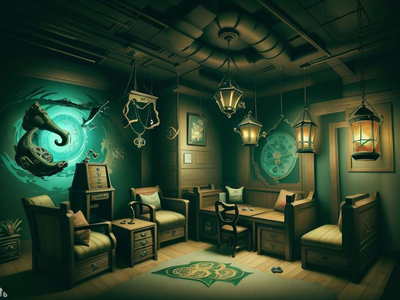

In [14]:
# SPACE SOUND runs for 5 minutes 
trigger_event("space sound") # in function explore

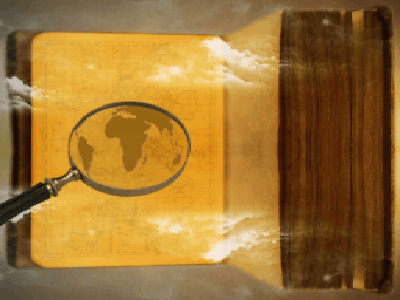

In [15]:
# examine 5sec
trigger_event("examine") # examine

⬇️ Downloading image.gif → c:\Users\sboub\Documents\GitHub\escape-room-2\assets\images/


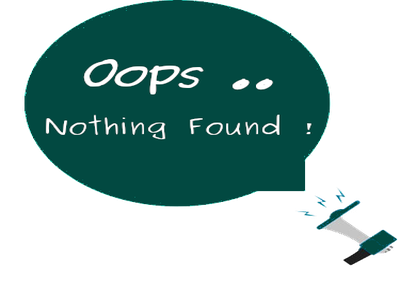

In [16]:
trigger_event("not found key") # not found key in examined item

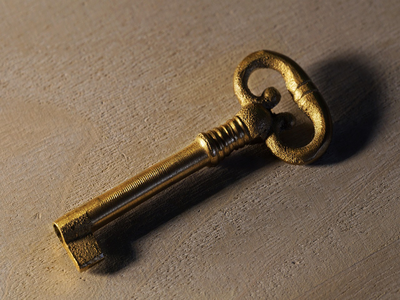

In [17]:
trigger_event("found key") # found key in examined item

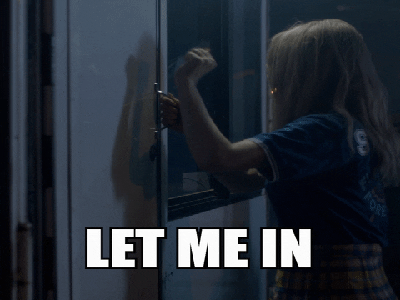

⚠️ Unknown trigger: quiz


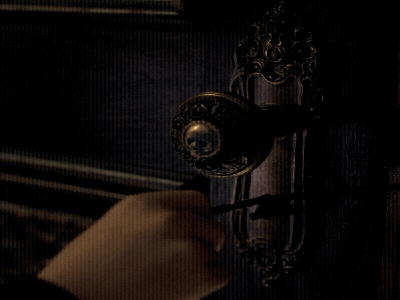

In [19]:
trigger_event("door locked") 
trigger_event("quiz") # we have a quiz to be able to unlock 
trigger_event("door unlocked")

In [ ]:
# TEST CALL TRIGGER EVENT

# examine 5sec
trigger_event("examine") # examine
trigger_event("not found key") # not found key in examined item
trigger_event("found key") # found key in examined item

# unlock door 5sec
trigger_event("door locked") # trying to unlock a door that we don't have the key in inventory for
trigger_event("quiz") # we have a quiz to be able to unlock 
trigger_event("door unlocked") # we have key in inventory and we answered the quiz correctly

# navigate 5sec
trigger_event("footstep")

# win 5sec
trigger_event("outside sound")

DEFINIG THE FUNCTION take_a_break()

**Step 1: The idea**

- When the player starts the game, we note the start time.
- Every second, we check how long the player has been playing.
- If it’s less than 40 minutes, keep playing.
- If it’s 40 minutes or more, stop the game and show this message:

TAKE A BREAK FOR MENTAL HEALTH: Breathe in, breathe out. Take some food, drink a cup of water & rest. Come back later.

- Then we wait 30 minutes before letting them play again

**Step 2: define what variables we need**

In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times

start_time = datetime.now()       # when the session started
break_until = None                # time when the break ends


**Step 3: The function**

In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times
import time

def take_a_break():
    global start_time, break_until

    now = datetime.now()

    # 1. If we are already in a break
    if break_until is not None:
        if now < break_until:
            remaining = break_until - now
            mins = int(remaining.total_seconds() // 60)
            secs = int(remaining.total_seconds() % 60)
            print(f"\n Still on break! Please wait {mins:02}:{secs:02} minutes.")
            return False
        else:
            # Break finished, reset timer
            print("\n Break finished! You can play again.\n")
            start_time = datetime.now()
            break_until = None
            return True

    # 2. If no break is active, check play time
    minutes_played = now - start_time
    if minutes_played >= timedelta(minutes=40):
        # Start break
        break_until = now + timedelta(minutes=1)
        print("""
========================================================
TAKE A BREAK FOR MENTAL HEALTH:
Breathe in, breathe out. Take some food, drink a cup of water & rest.
Come back later.
========================================================
""")
        return False
    else:
        return True




In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times
import time

# === GLOBAL VARIABLES ===
start_time = datetime.now()
break_until = None

def take_a_break():
    """Check if it's time for a break or if the player can keep playing."""
    global start_time, break_until

    now = datetime.now()

    # 1) If we are already in a break
    if break_until is not None:
        if now < break_until:
            remaining = break_until - now
            mins = int(remaining.total_seconds() // 60)
            secs = int(remaining.total_seconds() % 60)
            print(f"\nStill on break! Please wait {mins:02}:{secs:02} minutes.")
            return False
        else:
            # Break finished
            print("\nBreak finished! You can play again.\n")
            start_time = datetime.now()
            break_until = None
            return True

    # 2) If no break is active, check play time
    time_played = now - start_time

    # Change 'minutes' to 'seconds' for quick testing
    if time_played >= timedelta(minutes=40):
        break_until = now + timedelta(minutes=1)
        print("""
========================================================
TAKE A BREAK FOR MENTAL HEALTH:
Breathe in, breathe out. Take some food, drink a cup of water & rest.
Come back later.
========================================================
""")
        return False
    else:
        return True


# Hier ist a demo loop to show how take_a_break() works
if __name__ == "__main__":
    print("Demo started. Press Ctrl + C to stop.\n")

    try:
        while True:
            allowed = take_a_break()
            if allowed:
                print("Playing...")
            time.sleep(1)  # one tick per second
    except KeyboardInterrupt:
        print("\nStopped by user. Exiting cleanly.\n")


---
---
---
### SABINA COMMENTS

```
I see you don't have the code from the loop here. I would say to add that in so you can test the changes you do to the functions every time you make a change. At the moment it looks like you're focusing on all the different elements but don't have the full picture.

**So please try to make a working loop (either the one in the sample_code or one that you create with your own actions) as your next step before you work on any more details! The MVP (Minimum Viable Product) needs to come first!**

SABINA COMMENT: You can do `return action` instead of `break`. `return` automatically stops the function so because the while loop is INSIDE the function, then it will stop as well once the action is returned.

SABINA COMMENT: This would technically be a ValueError, not TypingError. Typing error is when you input a float instead of a string but Value error is when you put "get me out of the game" instead of "quit"
```